<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo sequence to sequence - Traductor

### Consigna

Replicar y extender el traductor:
- Replicar el modelo en PyTorch.
- Extender el entrenamiento a más datos y tamaños de secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.

Extras que se pueden probar: 
- Embeddingspre-entrenados para los dos idiomas
- Cambiar la estrategia de generación (por ejemplo muestreo aleatorio)

El objetivo es entrenar un modelo traductor sequence to sequence de inglés a español. Para esto se realizan las siguientes pruebas:
- Modelo visto en clase como baseline: cuenta con capas de embedding y LSTM (una capa en Encoder y Decoder). El embedding en inglés es pre-entrenado, y sus pesos no se actualizan durante entrenamiento, mientras que el de español se entrena desde cero.
- Duplicar la cantidad de datos de entrenamiento
- Aumentar el tamaño de las secuencias de entrenamiento
- Aumentar el hidden size de las LSTM
- Agregar una segunda capa a la LSTM en Encoder y Decoder. En el Decoder, los estados del Encoder entran directamente a la segunda capa (basándose en lo que realiza la arquitectura de Transformer, donde las salidas del Encoder entran a partir de la segunda capa)
- Convertir la LSTM en bidireccional. Esto ocurre sólo en el Encoder, ya que en el Decoder no se puede ver los tokens futuros 
- Convertir al embedding del Encoder en entrenable (se usan los pesos del pre-entrenado, pero se actualizan)
- Utilizar un mecanismo de atención, para que el Decoder pueda captar mejor la información del Encoder, y que está no quede compactada únicamente en el último estado oculto

Además, en base a los resultados del Desafío 3, donde en generación de secuencias la estrategia de generación por beam-search arrojó mejores resultados, se comparará la misma con la estrategia Greedy.


## 1. Datos

Se usa como Dataset una serie de frases en inglés con su correspondiente traducción en español:

In [148]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:

from torchinfo import summary

import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [150]:
# Descargar la carpeta de dataset
import gdown
import zipfile
if os.access('spa-eng', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = os.path.join("./Dataset", "spa-eng.zip")
        gdown.download(url, output, quiet=False)
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall("./Dataset")
else:
    print("El dataset ya se encuentra descargado")

# dataset_file

text_file = os.path.join("./Dataset", "spa-eng/spa.txt")
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]


Downloading...
From: http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
To: /home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/Desafio_4/Dataset/spa-eng.zip
100%|██████████| 2.64M/2.64M [00:01<00:00, 1.92MB/s]


### Funciones de guardado del modelo

Debido a los tiempos de entrenamiento largos, se utilizan funciones de guardado y carga del modelo y su historia:

In [151]:
import json

def save_checkpoint(folder, model, optimizer, history, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix, embedding_matrix_decoder=None):
    """
    Guarda todos los elementos necesarios para reconstruir el entrenamiento.
    """
    os.makedirs(folder, exist_ok=True)

    torch.save(model.state_dict(), os.path.join(folder, "seq2seq_model.pth"))
    torch.save(optimizer.state_dict(), os.path.join(folder, "optimizer_state.pth"))
    torch.save(config, os.path.join(folder, "config.pth"))

    np.save(os.path.join(folder, "embedding_matrix.npy"), embedding_matrix)
    if embedding_matrix_decoder is not None:
        np.save(os.path.join(folder, "embedding_matrix_decoder.npy"), embedding_matrix_decoder)

    with open(os.path.join(folder, "input_tokenizer.pkl"), "wb") as f:
        pickle.dump(input_tokenizer, f)
    with open(os.path.join(folder, "output_tokenizer.pkl"), "wb") as f:
        pickle.dump(output_tokenizer, f)
    with open(os.path.join(folder, "word2idx_inputs.pkl"), "wb") as f:
        pickle.dump(word2idx_inputs, f)
    with open(os.path.join(folder, "word2idx_outputs.pkl"), "wb") as f:
        pickle.dump(word2idx_outputs, f)

    with open(os.path.join(folder, "history.json"), "w") as f:
        json.dump(history, f)

    print(f"Checkpoint guardado en: {folder}")


def load_checkpoint(folder, Encoder, Decoder, Seq2Seq, device="cpu"):
    """
    Carga todo desde una carpeta y reconstruye el modelo listo para usar.
    Retorna: model, optimizer, history, config, tokenizers, vocabularios, embedding_matrix
    """
    # 1. Configuración
    config = torch.load(os.path.join(folder, "config.pth"), map_location=device)

    # 2. Tokenizers y vocabularios
    with open(os.path.join(folder, "input_tokenizer.pkl"), "rb") as f:
        input_tokenizer = pickle.load(f)
    with open(os.path.join(folder, "output_tokenizer.pkl"), "rb") as f:
        output_tokenizer = pickle.load(f)
    with open(os.path.join(folder, "word2idx_inputs.pkl"), "rb") as f:
        word2idx_inputs = pickle.load(f)
    with open(os.path.join(folder, "word2idx_outputs.pkl"), "rb") as f:
        word2idx_outputs = pickle.load(f)

    # 3. Embedding matrices (encoder obligatoria, decoder opcional)
    embedding_matrix_encoder = np.load(os.path.join(folder, "embedding_matrix.npy"))

    path_decoder = os.path.join(folder, "embedding_matrix_decoder.npy")
    embedding_matrix_decoder = np.load(path_decoder) if os.path.exists(path_decoder) else None

    vocab_size_encoder = int(embedding_matrix_encoder.shape[0])
    # 4. Modelo
    encoder = Encoder(
        vocab_size=vocab_size_encoder,
        embedding_matrix=embedding_matrix_encoder
    )

    if embedding_matrix_decoder is not None:
        decoder = Decoder(
            vocab_size=config["num_words_output"],
            output_dim=config["num_words_output"],
            embedding_matrix=embedding_matrix_decoder
        )
    else:
        print("No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.")
        decoder = Decoder(
            vocab_size=config["num_words_output"],
            output_dim=config["num_words_output"]
        )

    model = Seq2Seq(encoder, decoder)
    model.load_state_dict(torch.load(os.path.join(folder, "seq2seq_model.pth"), map_location=device))
    model.to(device)
    model.eval()

    # 5. Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    optimizer.load_state_dict(torch.load(os.path.join(folder, "optimizer_state.pth"), map_location=device))

    # 6. Historia
    with open(os.path.join(folder, "history.json"), "r") as f:
        history = json.load(f)

    print(f"Checkpoint cargado desde: {folder}")

    return {
        "model": model,
        "optimizer": optimizer,
        "history": history,
        "config": config,
        "input_tokenizer": input_tokenizer,
        "output_tokenizer": output_tokenizer,
        "word2idx_inputs": word2idx_inputs,
        "word2idx_outputs": word2idx_outputs,
        "embedding_matrix": embedding_matrix
    }


def check_checkpoint_exists(folder):
    """
    Verifica si existen todos los archivos necesarios en la carpeta.
    Retorna True si el checkpoint está completo.
    """
    required_files = [
        "seq2seq_model.pth",
        "optimizer_state.pth",
        "config.pth",
        "embedding_matrix.npy",
        "input_tokenizer.pkl",
        "output_tokenizer.pkl",
        "word2idx_inputs.pkl",
        "word2idx_outputs.pkl",
        "history.json"
    ]

    missing = [f for f in required_files if not os.path.exists(os.path.join(folder, f))]
    if missing:
        print(f"Faltan archivos en el checkpoint: {missing}")
        return False
    print(f"Checkpoint completo encontrado en: {folder}")
    return True

## 2. Entrenamiento Baseline
Se tomará el modelo entrenado en clase como Baseline para comparación al aplicar cambios:

### 2.1. Limitación dataset

In [152]:
# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

def generar_secuencias(lines, MAX_NUM_SENTENCES=6000):
    input_sentences = []
    output_sentences = []
    output_sentences_inputs = []
    count = 0

    for line in lines:
        count += 1
        if count > MAX_NUM_SENTENCES:
            break

        if '\t' not in line:
            continue

        # Input sentence --> eng
        # output --> spa
        input_sentence, output = line.rstrip().split('\t')

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)
    return input_sentences, output_sentences, output_sentences_inputs


# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 6000
input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 6000


In [153]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2.2. Preprocesamiento

In [154]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer

def tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE=8000):
    input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
    input_tokenizer.fit_on_texts(input_sentences)
    input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

    word2idx_inputs = input_tokenizer.word_index
    print("Palabras en el vocabulario:", len(word2idx_inputs))

    max_input_len = max(len(sen) for sen in input_integer_seq)
    print("Sentencia de entrada más larga:", max_input_len)


    # A los filtros de símbolos del Tokenizer agregamos el "¿",
    # sacamos los "<>" para que no afectar nuestros tokens
    output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
    output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
    output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
    output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

    word2idx_outputs = output_tokenizer.word_index
    print("Palabras en el vocabulario:", len(word2idx_outputs))

    num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
    max_out_len = max(len(sen) for sen in output_integer_seq)
    print("Sentencia de salida más larga:", max_out_len)

    return {
        'input_tokenizer': input_tokenizer,
        'output_tokenizer': output_tokenizer,
        'input_integer_seq': input_integer_seq,
        'output_integer_seq': output_integer_seq,
        'output_input_integer_seq': output_input_integer_seq,
        'word2idx_inputs': word2idx_inputs,
        'word2idx_outputs': word2idx_outputs,
        'max_input_len': max_input_len,
        'max_out_len': max_out_len,
        'num_words_output': num_words_output
    }

# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36


In [155]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 16
max_out_len = 18

In [156]:
from torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

Cantidad de rows del dataset: 6000
encoder_input_sequences shape: (6000, 16)
decoder_input_sequences shape: (6000, 18)
decoder_output_sequences shape: (6000, 18)


In [157]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        # Para CrossEntropyLoss: guardar los targets como índices de clase (LongTensor),
        # shape = (N, seq_len), dtype = torch.int64
        self.decoder_outputs = torch.from_numpy(decoder_output).to(torch.int64)

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = num_words_output
print("Output dim", output_dim)

encoder_input_size: 16
decoder_input_size: 18
Output dim 5722


In [158]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, drop_last=True)

Tamaño del conjunto de entrenamiento: 4800
Tamaño del conjunto de validacion: 1200


### 2.3. Preparar los embeddings

In [159]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [160]:
import logging
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [161]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [162]:
# Crear la Embedding matrix de las secuencias
# en ingles


def preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE):
    embed_dim = model_embeddings.N_FEATURES
    words_not_found = []

    # word_index provieen del tokenizer

    nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1) # vocab_size
    embedding_matrix = np.zeros((nb_words, embed_dim))
    for word, i in word2idx_inputs.items():
        if i >= nb_words:
            continue
        embedding_vector = model_embeddings.get_words_embeddings(word)[0]
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            
            embedding_matrix[i] = embedding_vector
        else:
            # words not found in embedding index will be all-zeros.
            words_not_found.append(word)

    print('Número de embeddings nulos:', np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix, words_not_found, nb_words

embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE)

Número de embeddings nulos: 30


In [163]:
nb_words

3852

In [164]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(3852, 50)

### 2.4. Entrenar modelo

In [165]:
from tqdm import tqdm

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
      
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random 
            # para ver en cada vuelta que técnica se aplica
            #input = top1            

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs

encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.to(device)
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
# asegurar consistencia: output_dim igual a num_words_output usado por dataset/one-hot
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.to(device)

model = Seq2Seq(encoder, decoder)
if cuda: model.to(device)

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica


### CORREGIR ERROR
#summary(model, input_data=(data_set[0:1][0], data_set[0:1][1]))

In [166]:
from tqdm import tqdm

def sequence_acc(y_pred, y_test):
    """
    Calcula la accuracy promedio por secuencia.
    y_pred: logits (batch, seq_len, vocab_size)
    y_test: índices (batch, seq_len)
    """
    y_pred_tag = y_pred.argmax(dim=-1)  # (batch, seq_len)
    y_test_tag = y_test if y_test.ndim == 2 else y_test.argmax(dim=-1)
    acc = (y_pred_tag == y_test_tag).float().mean().item()
    return acc


def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    train_loss, train_accuracy = [], []
    valid_loss, valid_accuracy = [], []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for train_encoder_input, train_decoder_input, train_target in loop:
            optimizer.zero_grad()

            # Forward
            output = model(train_encoder_input.to(device), train_decoder_input.to(device))


            # Calcular loss en toda la secuencia (más eficiente)
            loss = criterion(
                output.reshape(-1, output.shape[-1]),
                train_target.to(device).reshape(-1)
            )

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_train_accuracy += sequence_acc(output.to(device), train_target.to(device))

        epoch_train_loss /= len(train_loader)
        epoch_train_accuracy /= len(train_loader)
        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)


        # --- VALIDACIÓN COMPLETA ---
        model.eval()
        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        with torch.no_grad():
            for valid_encoder_input, valid_decoder_input, valid_target in valid_loader:
                output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))
                loss = criterion(
                    output.reshape(-1, output.shape[-1]),
                    valid_target.to(device).reshape(-1)
                )

                epoch_valid_loss += loss.item()
                epoch_valid_accuracy += sequence_acc(output.to(device), valid_target.to(device))

        epoch_valid_loss /= len(valid_loader)
        epoch_valid_accuracy /= len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch {epoch+1:02}/{epochs} | "
              f"Train loss: {epoch_train_loss:.3f} | "
              f"Train acc: {epoch_train_accuracy:.3f} | "
              f"Val loss: {epoch_valid_loss:.3f} | "
              f"Val acc: {epoch_valid_accuracy:.3f}")

    return {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }

In [167]:
carpeta = "Modelos_entrenados/Baseline"

modelo_entrenado = check_checkpoint_exists(carpeta)

if not modelo_entrenado:
    history1 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=10
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "num_layers": 1,           
        "lr": 0.1,
        "batch_size": 32,
        "epochs": 10,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history1, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder, Decoder, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history1 = data["history"]

Checkpoint completo encontrado en: Modelos_entrenados/Baseline
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Baseline


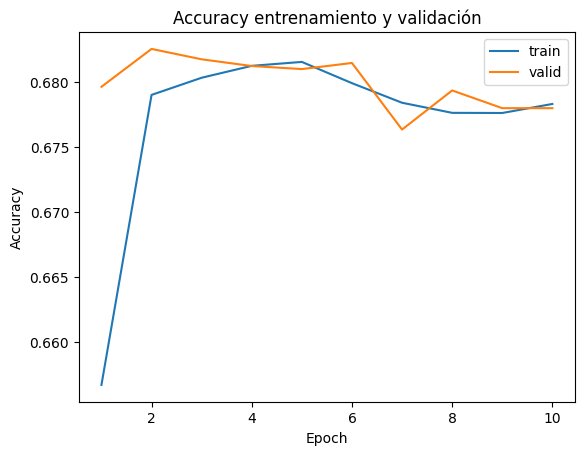

In [168]:
def graficar_accuracy(history):
    epoch_count = range(1, len(history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
    plt.title("Accuracy entrenamiento y validación") 
    plt.xlabel("Epoch") 
    plt.ylabel("Accuracy") 
    n_epochs = len(epoch_count)
    max_ticks = 20
    if n_epochs <= max_ticks:
        ticks = list(epoch_count)
    else:
        ticks = np.linspace(1, n_epochs, num=max_ticks, dtype=int)
    plt.show()

graficar_accuracy(history1)

Se observa que el Accuracy de validación y entrenamiento rondal el 68%.

### 2.5. Inferencia

In [169]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [170]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como "<sos>"
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

top1 = output.argmax(1).view(-1, 1)
idx = int(top1.cpu())
print("Index/token de salida:", idx)

word = idx2word_target[idx]
print("Palabra de salida:", word)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 225, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  15 225 134]]
Index/token de salida: 6
Palabra de salida: tom


In [171]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

In [172]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 225, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  15 225 134]]
Response: tom


In [173]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: Mary wants to buy a dress.
Response: tom no quiero que


Se observa que las secuencias generadas no son traducciones correctas.

## 3. Aumentar tamaño dataset entrenamiento
Duplicamos el tamaño del dataset de entrenamiento a 12000 líneas:

In [174]:
MAX_NUM_SENTENCES = 12000
input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)


salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, drop_last=True)

# --- CONTROL DE ÍNDICES VÁLIDOS ---
num_words_input = len(word2idx_inputs) + 1  # +1 por padding
num_words_output = len(word2idx_outputs) + 1

encoder_input_sequences[encoder_input_sequences >= num_words_input] = 0
decoder_input_sequences[decoder_input_sequences >= num_words_output] = 0
decoder_output_sequences[decoder_output_sequences >= num_words_output] = 0





Palabras en el vocabulario: 5409
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 8584
Sentencia de salida más larga: 36


In [175]:
embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(
    model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE
)



encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_datos"

modelo_entrenado = check_checkpoint_exists(carpeta)

if not modelo_entrenado:
    history2 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=10
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "num_layers": 1,            
        "lr": 0.1,
        "batch_size": 32,
        "epochs": 10,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history2, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder, Decoder, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history2 = data["history"]


Número de embeddings nulos: 53
Checkpoint completo encontrado en: Modelos_entrenados/Aumentar_datos
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Aumentar_datos


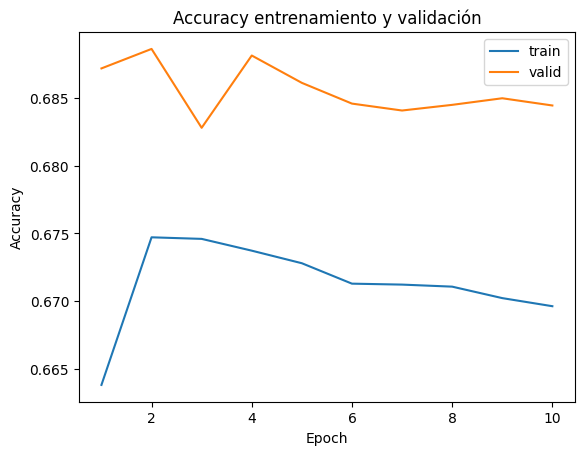

In [176]:
graficar_accuracy(history2)

Los valores de entrenamiento ahora son más bajos que los de validación, pero en general ambos son similares a los anteriores.

## 4. Aumentar tamaño de las secuencias
Aumentamos el tamaño de input maximo a 25 (la más larga en el dataset es 32) y del output a 30 (la más larga en el dataset es 36)

In [177]:
MAX_NUM_SENTENCES = 6000
max_input_len = 25
max_out_len = 30

input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)


salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, drop_last=True)

Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36


In [178]:
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE)

encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica


# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_secuencias"

modelo_entrenado = check_checkpoint_exists(carpeta)

if not modelo_entrenado:
    history3 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=10
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "num_layers": 1,           
        "lr": 0.1,
        "batch_size": 32,
        "epochs": 10,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history3, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder, Decoder, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history3 = data["history"]




Número de embeddings nulos: 30
Checkpoint completo encontrado en: Modelos_entrenados/Aumentar_secuencias
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Aumentar_secuencias


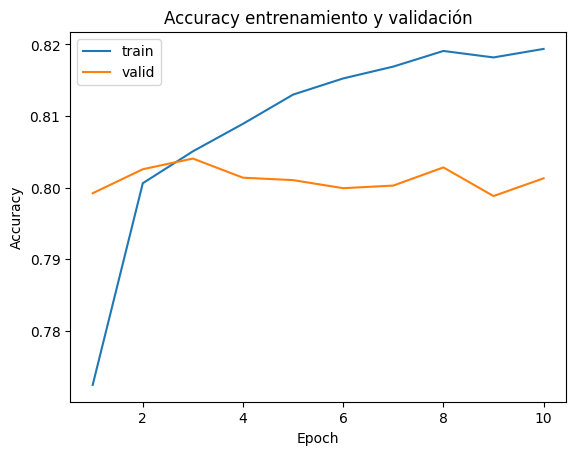

In [179]:
graficar_accuracy(history3)

Se observa una mejora significativa del accuracy respecto a las variantes anteriores, por lo que se mantiene la modificación para las siguientes variantes a entrenar.

## 5. Aumentar cantidad de hidden units de LSTM

Se duplica el hidden size de la LSTM de 128 a 256.

In [180]:
class Encoder_2(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 256
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder_2(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 256
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer


    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.fc1(lstm_output[:,-1,:])
        return out, (ht, ct)

In [181]:
encoder = Encoder_2(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder_2(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_hidden_size"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 10

if not modelo_entrenado:
    history4 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 256,      
        "num_layers": 1,           
        "lr": 0.1,
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history4, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder_2, Decoder_2, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history4 = data["history"]

Checkpoint completo encontrado en: Modelos_entrenados/Aumentar_hidden_size
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Aumentar_hidden_size


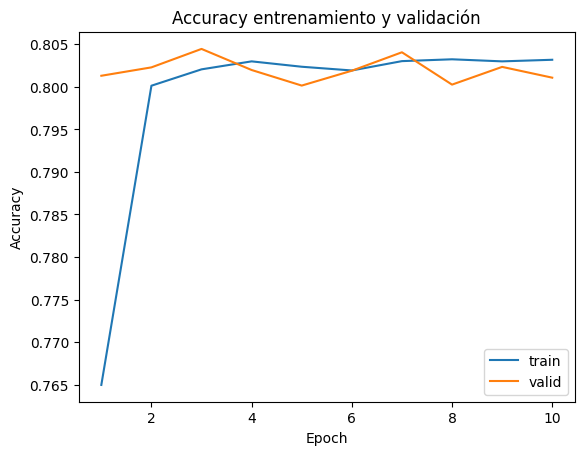

In [182]:
graficar_accuracy(history4)

No se observa mejora en los valores de accuracy obtenidos.

## 6. Aumentar cantidad de celdas LSTM

Se incorpora una segunda celda LSTM en Encoder y Decoder. Los valores de estado del Encoder ingresan a la segunda capa LSTM del Decoder.

In [183]:
class Encoder_3(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size1 = 128
        self.lstm_size2 = 64
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        # Primer LSTM
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim,
                             hidden_size=self.lstm_size1,
                             batch_first=True,
                             num_layers=self.num_layers)

        # Segundo LSTM, recibe como input la salida del primero
        self.lstm2 = nn.LSTM(input_size=self.lstm_size1,
                             hidden_size=self.lstm_size2,
                             batch_first=True,
                             num_layers=self.num_layers)

    def forward(self, x):
        out = self.embedding(x)
        lstm_out1, (h1, c1) = self.lstm1(out)  # [batch_size, seq_len, lstm_size1]
        lstm_out2, (h2, c2) = self.lstm2(lstm_out1)  # [batch_size, seq_len, lstm_size2]

        # Retornar hidden y cell del último LSTM
        return h2, c2

class Decoder_3(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size1 = 128
        self.lstm_size2 = 64
        self.num_layers = 1 
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        # Primer LSTM
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim,
                             hidden_size=self.lstm_size1,
                             batch_first=True,
                             num_layers=self.num_layers)

        # Segundo LSTM, recibe como input la salida del primero
        self.lstm2 = nn.LSTM(input_size=self.lstm_size1,
                             hidden_size=self.lstm_size2,
                             batch_first=True,
                             num_layers=self.num_layers)

        self.fc1 = nn.Linear(in_features=self.lstm_size2, out_features=self.output_dim) # Fully connected layer


    def forward(self, x, prev_state):
        out = self.embedding(x)
        # Primera LSTM SIN estado inicial (128)
        lstm_out1, _ = self.lstm1(out)
        # Segunda LSTM CON el estado del encoder (64)
        lstm_out2, (ht2, ct2) = self.lstm2(lstm_out1, prev_state)
        out = self.fc1(lstm_out2[:,-1,:])
        return out, (ht2, ct2)

class Seq2Seq_3(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size2 == decoder.lstm_size2, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
      
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random 
            # para ver en cada vuelta que técnica se aplica
            #input = top1            

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs


In [184]:
encoder = Encoder_3(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder_3(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq_3(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_capas_LSTM"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 10

if not modelo_entrenado:
    history5 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "hidden_size_lstm2": 64,
        "num_layers": 1,          
        "lr": 0.1,
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history5, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder_3, Decoder_3, Seq2Seq_3, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history5 = data["history"]

Checkpoint completo encontrado en: Modelos_entrenados/Aumentar_capas_LSTM
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Aumentar_capas_LSTM


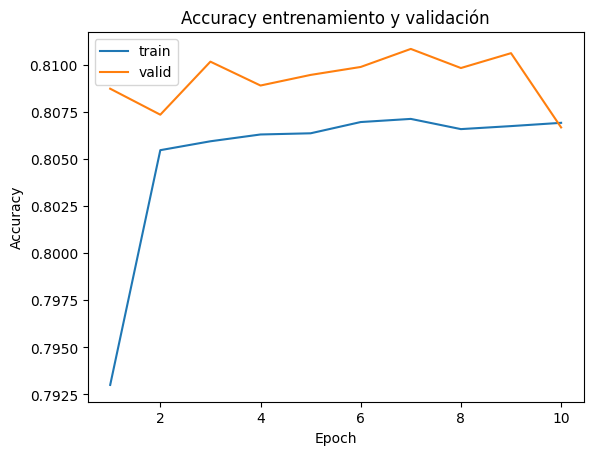

In [185]:
graficar_accuracy(history5)

Nuevamente, los valores obtenidos están en línea con los anteriores, no observándose mejoras significativas.

## 7. LSTM bidireccional Encoder
Ahora se modifica la LSTM por una bidireccional. Esto se hace solamente en el Encoder, ya que el Decoder no puede utilizar información futura. Además, se sumó una capa de dropout, dado que durante entrenamiento el valor de Accuracy de entrenamiento fue volviéndose muy superior al de validación, indicando overfitting.

In [ ]:
class Encoder_bidireccional(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, dropout_rate=0.2):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.dropout_rate = dropout_rate
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        
        # Dropout después del embedding
        self.dropout_embedding = nn.Dropout(self.dropout_rate)
        
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers,
            bidirectional=True,
            dropout=self.dropout_rate 
        )

    def forward(self, x):
        out = self.embedding(x)
        out = self.dropout_embedding(out)  # Dropout después del embedding
        lstm_output, (ht, ct) = self.lstm(out)
        
        # Usar solo el estado forward para evitar problemas de dimensiones
        # Esto mantiene la ventaja bidireccional del encoder pero evita incompatibilidades
        ht_forward = ht[0].unsqueeze(0)  # Solo forward, shape (1, batch, 128)
        ct_forward = ct[0].unsqueeze(0)  # Solo forward, shape (1, batch, 128)
        
        return (ht_forward, ct_forward)

class Decoder_bidreccional(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None, dropout_rate=0.2):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128  # Mismo tamaño que el encoder (no bidireccional)
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        # Dropout después del embedding
        self.dropout_embedding = nn.Dropout(self.dropout_rate)

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,  # 128 - compatible con encoder
            batch_first=True,
            num_layers=self.num_layers,
            dropout=self.dropout_rate 
        )
        
        # Dropout antes de la capa final
        self.dropout_output = nn.Dropout(self.dropout_rate)
        self.fc1 = nn.Linear(self.lstm_size, self.output_dim)
        # SIN SOFTMAX - usar solo logits para evitar problemas de gradientes

    def forward(self, x, prev_state):
        out = self.embedding(x)
        out = self.dropout_embedding(out)  # Dropout después del embedding
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.dropout_output(lstm_output[:,-1,:])  
        out = self.fc1(out)  # Solo logits, sin softmax
        return out, (ht, ct)


In [187]:
# Crear el modelo bidireccional con dropout
dropout_rate = 0.2  # 20% de dropout por defecto

encoder_bidireccional = Encoder_bidireccional(vocab_size=nb_words, 
                                            embedding_matrix=embedding_matrix, 
                                            dropout_rate=dropout_rate)
if cuda: encoder_bidireccional.to(device)

# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder_bidreccional = Decoder_bidreccional(vocab_size=num_words_output, 
                                          output_dim=num_words_output,
                                          dropout_rate=dropout_rate)
if cuda: decoder_bidreccional.to(device)

model = Seq2Seq(encoder_bidireccional, decoder_bidreccional)
if cuda: model.to(device)

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Learning rate más conservador
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

print(f"✓ Modelo bidireccional creado con dropout_rate = {dropout_rate}")
print(f"✓ Learning rate = 0.01")
print(f"✓ Dispositivo: {'CUDA' if cuda else 'CPU'}")

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/LSTM_bidireccional"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 20

if not modelo_entrenado:
    print(f"\nIniciando entrenamiento por {n_epochs} épocas...")
    history6 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,      
        "num_layers": 1,           
        "lr": 0.01,  # Learning rate más conservador
        "dropout_rate": dropout_rate,  # Nuevo parámetro
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history6, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
    print("Modelo entrenado y guardado exitosamente")
else:
    print(f"\nCargando modelo existente desde {carpeta}")
    data = load_checkpoint(carpeta, Encoder_bidireccional, Decoder_bidreccional, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history6 = data["history"]
    print("Modelo cargado exitosamente")


✓ Modelo bidireccional creado con dropout_rate = 0.2
✓ Learning rate = 0.01
✓ Dispositivo: CUDA
Checkpoint completo encontrado en: Modelos_entrenados/LSTM_bidireccional

Cargando modelo existente desde Modelos_entrenados/LSTM_bidireccional
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/LSTM_bidireccional
Modelo cargado exitosamente


/home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


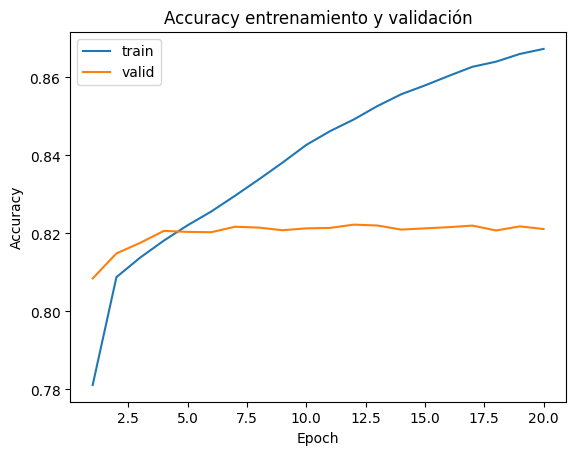

In [188]:
graficar_accuracy(history6)


Se observa que los valores mejoran con respecto a las pruebas anteriores. No obstante, se observa un overfitting incluso contando con las capas de Dropout. Se mantiene la capa bidireccional para la siguiente prueba.

## 8. Embedding de encoder entrenable

En esta prueba, se mantiene la capa bidireccional, y además permitimos que la capa de embedding del Encoder se entrena (aunque parte de los valores pre-entrenados).

In [189]:
class Encoder_bidireccional_2(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, dropout_rate=0.2):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.dropout_rate = dropout_rate
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        # Dropout después del embedding
        self.dropout_embedding = nn.Dropout(self.dropout_rate)
        
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers,
            bidirectional=True,
            dropout=self.dropout_rate 
        )

    def forward(self, x):
        out = self.embedding(x)
        out = self.dropout_embedding(out)  # Dropout después del embedding
        lstm_output, (ht, ct) = self.lstm(out)
        
        # CAMBIO CLAVE: Usar solo el estado forward para evitar problemas de dimensiones
        # Esto mantiene la ventaja bidireccional del encoder pero evita incompatibilidades
        ht_forward = ht[0].unsqueeze(0)  # Solo forward, shape (1, batch, 128)
        ct_forward = ct[0].unsqueeze(0)  # Solo forward, shape (1, batch, 128)
        
        return (ht_forward, ct_forward)

class Decoder_bidreccional_2(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None, dropout_rate=0.2):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128  # Mismo tamaño que el encoder (no bidireccional)
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        # Dropout después del embedding
        self.dropout_embedding = nn.Dropout(self.dropout_rate)

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,  # 128 - compatible con encoder
            batch_first=True,
            num_layers=self.num_layers,
            dropout=self.dropout_rate 
        )
        
        # Dropout antes de la capa final
        self.dropout_output = nn.Dropout(self.dropout_rate)
        self.fc1 = nn.Linear(self.lstm_size, self.output_dim)
        # SIN SOFTMAX - usar solo logits para evitar problemas de gradientes

    def forward(self, x, prev_state):
        out = self.embedding(x)
        out = self.dropout_embedding(out)  # Dropout después del embedding
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.dropout_output(lstm_output[:,-1,:])  # Dropout antes de la capa final
        out = self.fc1(out)  # Solo logits, sin softmax
        return out, (ht, ct)

In [190]:
# Crear el modelo bidireccional con dropout
dropout_rate = 0.2  # 20% de dropout por defecto

encoder_bidireccional = Encoder_bidireccional_2(vocab_size=nb_words, 
                                            embedding_matrix=embedding_matrix, 
                                            dropout_rate=dropout_rate)
if cuda: encoder_bidireccional.to(device)

# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder_bidreccional = Decoder_bidreccional_2(vocab_size=num_words_output, 
                                          output_dim=num_words_output,
                                          dropout_rate=dropout_rate)
if cuda: decoder_bidreccional.to(device)

model = Seq2Seq(encoder_bidireccional, decoder_bidreccional)
if cuda: model.to(device)

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Learning rate más conservador
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

print(f"✓ Modelo bidireccional creado con dropout_rate = {dropout_rate}")
print(f"✓ Learning rate = 0.01")
print(f"✓ Dispositivo: {'CUDA' if cuda else 'CPU'}")

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Embedding_encoder_entrenable"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 20

if not modelo_entrenado:
    print(f"\nIniciando entrenamiento por {n_epochs} épocas...")
    history7 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,      
        "num_layers": 1,           
        "lr": 0.01,  # Learning rate más conservador
        "dropout_rate": dropout_rate,  # Nuevo parámetro
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history7, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
    print("Modelo entrenado y guardado exitosamente")
else:
    print(f"\nCargando modelo existente desde {carpeta}")
    data = load_checkpoint(carpeta, Encoder_bidireccional, Decoder_bidreccional, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history7 = data["history"]
    print("Modelo cargado exitosamente")


/home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


✓ Modelo bidireccional creado con dropout_rate = 0.2
✓ Learning rate = 0.01
✓ Dispositivo: CUDA
Checkpoint completo encontrado en: Modelos_entrenados/Embedding_encoder_entrenable

Cargando modelo existente desde Modelos_entrenados/Embedding_encoder_entrenable
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Embedding_encoder_entrenable
Modelo cargado exitosamente


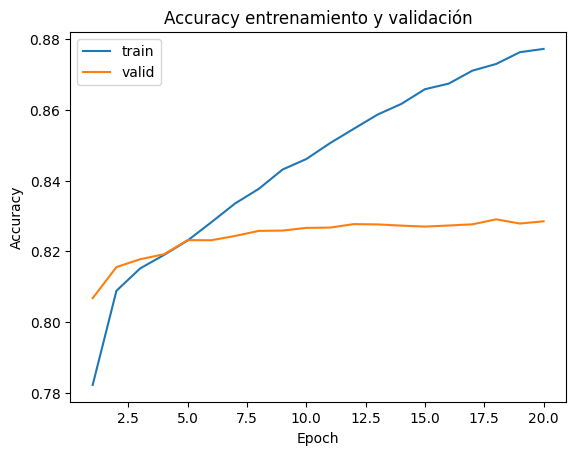

In [191]:
graficar_accuracy(history7)

El valor se mantiene en línea con los anteriores. Se observa un overfitting dado que la métrica de entrenamiento mejora por encima de la de validación.

## 9. Attention

En esta prueba, se incorporan mecanismos de atención entre el Decoder y Encoder, de forma que el Decoder tenga todo el output del Encoder, y no sólo el último estado oculto, de forma que capture mejor el contexto.

In [192]:
# ============================
# Encoder BiLSTM con ATTENTION
# ============================
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder_bidireccional_attn(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, hidden_size=128, num_layers=1, dropout_rate=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        # si querés congelar el embedding del encoder:
        # self.embedding.weight.requires_grad = False

        self.dropout_emb = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
            input_size=self.emb_dim,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )

    def forward(self, x):
        """
        x: [B, L_src]
        return:
          enc_out: [B, L_src, 2H]
          init_state: (h0, c0) con sólo la dir. forward para casar H
        """
        e = self.dropout_emb(self.embedding(x))
        enc_out, (ht, ct) = self.lstm(e)          # enc_out: [B,L,2H]
        # usar sólo forward (índice 0) para H=hidden_size
        h0 = ht[0].unsqueeze(0)                   # [1,B,H]
        c0 = ct[0].unsqueeze(0)                   # [1,B,H]
        return enc_out, (h0, c0)


# ====================================
# Decoder con ATTENTION (Luong "dot")
# - Proyecta enc_out (2H) -> H
# - scores_{t,i} = dec_t · (W_enc * enc_out_i)
# - Mask de padding en fuente
# ====================================
class Decoder_bidreccional_attn(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None,
                 hidden_size=128, num_layers=1, dropout_rate=0.2, enc_out_dim=256):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            # si querés congelar el embedding del decoder:
            # self.embedding.weight.requires_grad = False

        self.dropout_emb = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
            input_size=self.emb_dim,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )

        # Proyección de estados del encoder (2H -> H) para "dot"
        self.enc_proj = nn.Linear(enc_out_dim, hidden_size, bias=False)
        self.dropout_out = nn.Dropout(dropout_rate)
        # Combinar [dec_t, context_t] -> vocab
        self.fc1 = nn.Linear(hidden_size * 2, output_dim)

    def forward(self, x, prev_state, enc_out, src_pad_mask=None):
        """
        x: [B, T_dec]
        prev_state: (h0,c0) [1,B,H]
        enc_out: [B, L_src, 2H]
        src_pad_mask: [B, L_src], True en PAD
        """
        B, L_src, _ = enc_out.size()

        # 1) Decoder "puro"
        emb = self.dropout_emb(self.embedding(x))               # [B,T,E]
        dec_seq, (ht, ct) = self.lstm(emb, prev_state)          # [B,T,H]

        # 2) Proyección encoder para dot
        enc_proj = self.enc_proj(enc_out)                       # [B,L_src,H]

        # 3) Scores y máscara de padding fuente
        # scores_{t,i} = dec_t · enc_proj_i
        scores = torch.bmm(dec_seq, enc_proj.transpose(1, 2))   # [B,T,L_src]
        if src_pad_mask is not None:
            # src_pad_mask True en PAD -> -inf para que no atienda ahí
            scores = scores.masked_fill(src_pad_mask.unsqueeze(1), float('-inf'))

        attn = torch.softmax(scores, dim=-1)                    # [B,T,L_src]

        # 4) Contexto
        context = torch.bmm(attn, enc_proj)                     # [B,T,H]

        # 5) Fusionar y proyectar a vocab
        fused = torch.cat([dec_seq, context], dim=-1)           # [B,T,2H]
        logits = self.fc1(self.dropout_out(fused))              # [B,T,V]
        return logits, (ht, ct), attn


# ======================
# Wrapper Seq2Seq + Attn
# ======================
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder_attn, pad_idx=0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder_attn
        self.pad_idx = pad_idx

    def forward(self, enc_in, dec_in):
        """
        enc_in: [B,L_src] (con PAD=0)
        dec_in: [B,T_dec] (teacher forcing)
        """
        # 1) Encode
        enc_out, init_state = self.encoder(enc_in)              # enc_out: [B,L,2H]

        # 2) Máscara de PAD en fuente
        src_pad_mask = (enc_in == self.pad_idx)                 # [B,L]

        # 3) Decode con atención (logits en TODOS los pasos)
        logits, _, _ = self.decoder(dec_in, init_state, enc_out, src_pad_mask)
        return logits


In [ ]:
# =============== Crear modelo con ATTENTION (drop-in) ===============
dropout_rate = 0.2
hidden_size = 128
num_layers = 1
pad_idx = 0

encoder_attn = Encoder_bidireccional_attn(
    vocab_size=nb_words,
    embedding_matrix=embedding_matrix,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate
)
decoder_attn =  Decoder_bidreccional_attn(
    vocab_size=num_words_output,
    output_dim=num_words_output,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    enc_out_dim=hidden_size*2   # 2H (BiLSTM)

)

model = Seq2SeqAttention(encoder_attn, decoder_attn, pad_idx=pad_idx)
model = model.to(device)

# Optimizador y loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 1e-3 suele ir mejor que 1e-2
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

#  =============== Train o Load (mismo estilo) ===============
carpeta = "Modelos_entrenados/Embedding_encoder_con_attention"

modelo_entrenado = check_checkpoint_exists(carpeta)
n_epochs = 50

if not modelo_entrenado:
    print(f"\nIniciando entrenamiento por {n_epochs} épocas...")
    history_attn = train(
        model,
        train_loader,
        valid_loader,
        optimizer,
        criterion,
        epochs=n_epochs
    )

    config = {
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        "embedding_dim_enc": int(embedding_matrix.shape[1]),
        "embedding_dim_dec": int(embedding_matrix.shape[1]),  # cambia si usás embedding_matrix_decoder
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "lr": 0.001,
        "dropout_rate": dropout_rate,
        "batch_size": 32,
        "epochs": n_epochs,

        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        "embedding_source_enc": getattr(model_embeddings, "name", "custom"),
        "embedding_source_dec": "same_as_enc",  # o "spanish_pretrained" si usaste embedding_matrix_decoder
        "variant": "seq2seq_attention_luong_dot"
    }


    save_checkpoint(
        carpeta, model, optimizer, history_attn, config,
        input_tokenizer, output_tokenizer,
        word2idx_inputs, word2idx_outputs, embedding_matrix
        # , embedding_matrix_decoder=embedding_matrix_decoder
    )
    print("Modelo entrenado y guardado exitosamente")
else:
    print(f"\nCargando modelo existente desde {carpeta}")
    data = load_checkpoint(
        carpeta,
        Encoder_bidireccional_attn, Decoder_bidreccional_attn, Seq2SeqAttention,
        device="cuda" if cuda else "cpu"
    )
    model = data["model"]
    optimizer = data["optimizer"]
    history_attn = data["history"]
    print("Modelo cargado exitosamente")


Faltan archivos en el checkpoint: ['seq2seq_model.pth', 'optimizer_state.pth', 'config.pth', 'embedding_matrix.npy', 'input_tokenizer.pkl', 'output_tokenizer.pkl', 'word2idx_inputs.pkl', 'word2idx_outputs.pkl', 'history.json']

Iniciando entrenamiento por 50 épocas...


Epoch 01/50 | Train loss: 6.273 | Train acc: 0.038 | Val loss: 5.785 | Val acc: 0.043


Epoch 02/50 | Train loss: 5.547 | Train acc: 0.045 | Val loss: 5.612 | Val acc: 0.049


Epoch 03/50 | Train loss: 5.174 | Train acc: 0.051 | Val loss: 5.363 | Val acc: 0.054


Epoch 04/50 | Train loss: 4.819 | Train acc: 0.055 | Val loss: 5.223 | Val acc: 0.057


Epoch 05/50 | Train loss: 4.485 | Train acc: 0.059 | Val loss: 5.114 | Val acc: 0.061


Epoch 06/50 | Train loss: 4.180 | Train acc: 0.063 | Val loss: 5.029 | Val acc: 0.065


Epoch 07/50 | Train loss: 3.883 | Train acc: 0.069 | Val loss: 5.015 | Val acc: 0.068


Epoch 08/50 | Train loss: 3.622 | Train acc: 0.073 | Val loss: 4.983 | Val acc: 0.071


Epoch 09/50 | Train loss: 3.360 | Train acc: 0.078 | Val loss: 5.008 | Val acc: 0.071


Epoch 10/50 | Train loss: 3.116 | Train acc: 0.085 | Val loss: 5.016 | Val acc: 0.074


Epoch 11/50 | Train loss: 2.902 | Train acc: 0.093 | Val loss: 5.050 | Val acc: 0.075


Epoch 12/50 | Train loss: 2.709 | Train acc: 0.100 | Val loss: 5.079 | Val acc: 0.076


Epoch 13/50 | Train loss: 2.522 | Train acc: 0.108 | Val loss: 5.083 | Val acc: 0.078


Epoch 14/50 | Train loss: 2.372 | Train acc: 0.113 | Val loss: 5.147 | Val acc: 0.078


Epoch 15/50 | Train loss: 2.235 | Train acc: 0.119 | Val loss: 5.125 | Val acc: 0.081


Epoch 16/50 | Train loss: 2.116 | Train acc: 0.124 | Val loss: 5.143 | Val acc: 0.081


Epoch 17/50 | Train loss: 2.007 | Train acc: 0.129 | Val loss: 5.157 | Val acc: 0.082


Epoch 18/50 | Train loss: 1.905 | Train acc: 0.133 | Val loss: 5.211 | Val acc: 0.082


Epoch 19/50 | Train loss: 1.821 | Train acc: 0.136 | Val loss: 5.214 | Val acc: 0.085


Epoch 20/50 | Train loss: 1.732 | Train acc: 0.140 | Val loss: 5.223 | Val acc: 0.085


Epoch 21/50 | Train loss: 1.663 | Train acc: 0.144 | Val loss: 5.240 | Val acc: 0.085


Epoch 22/50 | Train loss: 1.587 | Train acc: 0.147 | Val loss: 5.233 | Val acc: 0.085


Epoch 23/50 | Train loss: 1.529 | Train acc: 0.150 | Val loss: 5.306 | Val acc: 0.087


Epoch 24/50 | Train loss: 1.480 | Train acc: 0.152 | Val loss: 5.288 | Val acc: 0.086


Epoch 25/50 | Train loss: 1.409 | Train acc: 0.155 | Val loss: 5.328 | Val acc: 0.088


Epoch 26/50 | Train loss: 1.358 | Train acc: 0.158 | Val loss: 5.310 | Val acc: 0.088


Epoch 27/50 | Train loss: 1.296 | Train acc: 0.161 | Val loss: 5.313 | Val acc: 0.089


Epoch 28/50 | Train loss: 1.261 | Train acc: 0.163 | Val loss: 5.359 | Val acc: 0.089


Epoch 29/50 | Train loss: 1.212 | Train acc: 0.165 | Val loss: 5.340 | Val acc: 0.089


Epoch 30/50 | Train loss: 1.177 | Train acc: 0.167 | Val loss: 5.355 | Val acc: 0.089


Epoch 31/50 | Train loss: 1.141 | Train acc: 0.168 | Val loss: 5.396 | Val acc: 0.090


Epoch 32/50 | Train loss: 1.104 | Train acc: 0.170 | Val loss: 5.396 | Val acc: 0.090


Epoch 33/50 | Train loss: 1.060 | Train acc: 0.173 | Val loss: 5.418 | Val acc: 0.090


Epoch 34/50 | Train loss: 1.026 | Train acc: 0.174 | Val loss: 5.437 | Val acc: 0.090


Epoch 35/50 | Train loss: 1.004 | Train acc: 0.176 | Val loss: 5.478 | Val acc: 0.091


Epoch 36/50 | Train loss: 0.984 | Train acc: 0.177 | Val loss: 5.439 | Val acc: 0.090


Epoch 37/50 | Train loss: 0.951 | Train acc: 0.179 | Val loss: 5.484 | Val acc: 0.092


Epoch 38/50 | Train loss: 0.919 | Train acc: 0.180 | Val loss: 5.502 | Val acc: 0.092


Epoch 39/50 | Train loss: 0.889 | Train acc: 0.182 | Val loss: 5.479 | Val acc: 0.092


Epoch 40/50 | Train loss: 0.874 | Train acc: 0.182 | Val loss: 5.517 | Val acc: 0.092


Epoch 41/50 | Train loss: 0.842 | Train acc: 0.185 | Val loss: 5.559 | Val acc: 0.093


Epoch 42/50 | Train loss: 0.824 | Train acc: 0.186 | Val loss: 5.581 | Val acc: 0.093


Epoch 43/50 | Train loss: 0.792 | Train acc: 0.188 | Val loss: 5.613 | Val acc: 0.092


Epoch 44/50 | Train loss: 0.771 | Train acc: 0.189 | Val loss: 5.656 | Val acc: 0.092


Epoch 45/50 | Train loss: 0.769 | Train acc: 0.188 | Val loss: 5.597 | Val acc: 0.093


Epoch 46/50 | Train loss: 0.741 | Train acc: 0.191 | Val loss: 5.601 | Val acc: 0.093


Epoch 47/50 | Train loss: 0.728 | Train acc: 0.190 | Val loss: 5.617 | Val acc: 0.093


Epoch 48/50 | Train loss: 0.707 | Train acc: 0.192 | Val loss: 5.605 | Val acc: 0.094


Epoch 49/50 | Train loss: 0.683 | Train acc: 0.194 | Val loss: 5.719 | Val acc: 0.093


Epoch 50/50 | Train loss: 0.665 | Train acc: 0.194 | Val loss: 5.665 | Val acc: 0.094
Checkpoint guardado en: Modelos_entrenados/Embedding_encoder_con_attention
Modelo entrenado y guardado exitosamente


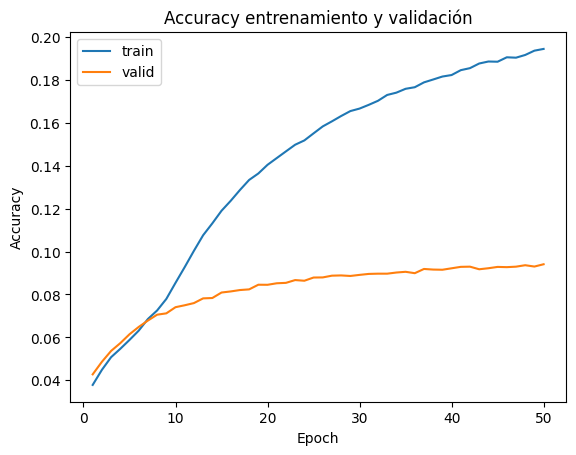

In [194]:
graficar_accuracy(history_attn)

Se observa un accuracy significativamente más bajo que en los demás casos, además de un claro ejemplo de overfitting. No obstante, en pruebas de traducción este modelo fue el que más acercó a dar inferencias coherentes, por lo que utilizamos el mismo.

## 10. Generar inferencias

Generamos cinco inferencias, primero tomando del dataset, y luego generando frases nuevas. Para ambos casos, se comparan los resultados de la estrategia Greedy y Beam Search.

In [195]:
# ===============================================================
# Reconstruir idx2word_outputs si no existe
# ===============================================================
if 'idx2word_outputs' not in globals():
    if 'output_tokenizer' in globals() and hasattr(output_tokenizer, 'index_word'):
        idx2word_outputs = output_tokenizer.index_word
    elif 'word2idx_outputs' in globals():
        idx2word_outputs = {v: k for k, v in word2idx_outputs.items()}
    else:
        raise ValueError("No se encontró ni 'output_tokenizer' ni 'word2idx_outputs'.")


@torch.no_grad()
def greedy_decode(model, encoder_input, sos_idx, eos_idx, max_len, device, pad_idx=0):
    """
    Decodificación Greedy para un modelo Seq2Seq:
    - model(encoder_input, decoder_input) -> logits [B, T, V]
    """
    model.eval()
    if encoder_input.dim() == 1:
        encoder_input = encoder_input.unsqueeze(0)
    encoder_input = encoder_input.to(device)

    dec = torch.full((1, 1), sos_idx, dtype=torch.long, device=device)

    for _ in range(max_len):
        logits = model(encoder_input, dec)
        next_token = logits[:, -1, :].argmax(dim=-1)
        #  Forzamos el token al mismo device que dec
        next_token = next_token.to(device)
        dec = torch.cat([dec, next_token.unsqueeze(1)], dim=1)
        if next_token.item() == eos_idx:
            break

    return dec.squeeze(0).tolist()[1:]  # sin <sos>


@torch.no_grad()
def beam_search_decode(model, encoder_input, sos_idx, eos_idx, max_len, device,
                       beam_size=5, length_penalty=1.0, pad_idx=0,
                       temperature=1.0, top_k=None):
    """
    Beam Search estándar para Seq2Seq.
    """
    model.eval()
    if encoder_input.dim() == 1:
        encoder_input = encoder_input.unsqueeze(0)
    encoder_input = encoder_input.to(device)

    beams = [(0.0, torch.full((1, 1), sos_idx, dtype=torch.long, device=device))]
    finished = []

    for _ in range(max_len):
        new_beams = []
        for logp, seq in beams:
            if seq[0, -1].item() == eos_idx:
                finished.append((logp, seq.clone()))
                continue

            logits = model(encoder_input, seq)[:, -1, :]
            if temperature != 1.0:
                logits /= temperature

            if top_k is not None and 0 < top_k < logits.size(-1):
                topk_vals, topk_idx = torch.topk(logits, k=top_k, dim=-1)
                log_probs = F.log_softmax(topk_vals, dim=-1)
                cand_ids = topk_idx.squeeze(0)
            else:
                log_probs = F.log_softmax(logits, dim=-1)
                cand_ids = torch.arange(log_probs.size(-1), device=device)

            log_probs = log_probs.squeeze(0)
            topk_logp, topk_id = torch.topk(log_probs, k=min(beam_size, log_probs.numel()))
            for add_logp, token_rank in zip(topk_logp.tolist(), topk_id.tolist()):
                token_id = cand_ids[token_rank].item()
                new_seq = torch.cat([seq, torch.tensor([[token_id]], device=device)], dim=1)
                new_beams.append((logp + add_logp, new_seq))

        if not new_beams and not finished:
            break

        def norm_score(tup):
            lp, s = tup
            # s: [1, t_con_sos]
            seq_len_wo_sos = max(1, s.size(1) - 1)
            denom = (seq_len_wo_sos ** length_penalty) if length_penalty != 1.0 else seq_len_wo_sos
            return lp / denom


        new_beams.sort(key=norm_score, reverse=True)
        beams = new_beams[:beam_size]

        if all(seq[0, -1].item() == eos_idx for _, seq in beams):
            finished.extend(beams)
            break

    pool = finished if finished else beams
    pool.sort(key=lambda x: x[0] / (max(1, x[1].size(1) - 1) ** length_penalty), reverse=True)
    best = pool[0][1].squeeze(0).tolist()
    return best[1:]  # sin <sos>

def ids_to_sentence(ids, idx2word, eos_idx, skip_special=True):
    out = []
    for i in ids:
        if i == eos_idx:
            break
        tok = idx2word.get(i, f"<unk:{i}>")
        if skip_special and tok in ("<sos>", "<eos>", "<pad>"):
            continue
        out.append(tok)
    return " ".join(out).strip()


In [196]:
# ===============================================================
# Ejemplo de inferencia Greedy y Beam Search en 5 muestras
# ===============================================================
import random

SEED = 42  # <- cambiálo si querés otra corrida reproducible

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Para que cuDNN no meta heurísticas no determinísticas
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Parámetros necesarios ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# Vocab inverso de entrada
if 'idx2word_inputs' not in globals():
    if 'input_tokenizer' in globals() and hasattr(input_tokenizer, 'index_word'):
        idx2word_inputs = input_tokenizer.index_word
    elif 'word2idx_inputs' in globals():
        idx2word_inputs = {v: k for k, v in word2idx_inputs.items()}
    else:
        raise ValueError("No se encontró idx2word_inputs (ni input_tokenizer ni word2idx_inputs).")

sos_idx = word2idx_outputs["<sos>"]
eos_idx = word2idx_outputs["<eos>"]
pad_idx = 0

def get_item(i):
    if 'data_set' in globals() and data_set is not None:
        enc, _, dec_out = data_set[i]
        if dec_out.dim() == 3:
            dec_out = dec_out.argmax(dim=-1)
        return enc.long(), dec_out.long()
    else:
        enc = torch.from_numpy(encoder_input_sequences[i]).long()
        tgt = torch.from_numpy(decoder_output_sequences[i]).long()
        return enc, tgt

def ids_to_sentence_input(ids, idx2word, skip_special=True):
    out = []
    for i in ids:
        tok = idx2word.get(int(i), f"<unk:{i}>")
        if skip_special and tok in ("<sos>", "<eos>", "<pad>"):
            continue
        out.append(tok)
    return " ".join(out).strip()

# --- Selecciono 5 ejemplos aleatorios ---
N = 5
pool_size = len(data_set) if 'data_set' in globals() and data_set is not None else len(encoder_input_sequences)
indices = random.sample(range(pool_size), k=min(N, pool_size))

for idx in indices:
    enc, tgt = get_item(idx)
    enc = enc.unsqueeze(0) if enc.dim() == 1 else enc

    greedy_ids = greedy_decode(model, enc, sos_idx, eos_idx, max_out_len, device, pad_idx)
    beam_ids   = beam_search_decode(model, enc, sos_idx, eos_idx, max_out_len, device,
                                    beam_size=10, length_penalty=0.1, pad_idx=pad_idx)

    ref_text    = ids_to_sentence(tgt.tolist(), idx2word_outputs, eos_idx)
    greedy_text = ids_to_sentence(greedy_ids, idx2word_outputs, eos_idx)
    beam_text   = ids_to_sentence(beam_ids, idx2word_outputs, eos_idx)
    # ids para imprimir (sin padding=0)
    src_ids_for_print = [int(t) for t in enc.squeeze(0).tolist() if t != 0]
    src_text = ids_to_sentence_input(src_ids_for_print, idx2word_inputs)

    print("="*100)
    print(f"[{idx}] Original inglés         : {src_text}")
    print(f"[{idx}] Traducción de referencia: {ref_text}")
    print(f"[{idx}] GREEDY                  : {greedy_text}")
    print(f"[{idx}] BEAM                    : {beam_text}")
    print("="*100)

[5238] Original inglés         : good always wins over evil
[5238] Traducción de referencia: el bien gana siempre al mal
[5238] GREEDY                  : bueno se sentía se alejó
[5238] BEAM                    : de quién son ser bella
[912] Original inglés         : you'll miss the train
[912] Traducción de referencia: perderás el tren
[912] GREEDY                  : perderás el tren
[912] BEAM                    : perderás el tren
[204] Original inglés         : christmas is december 25th
[204] Traducción de referencia: la navidad es el 25 de diciembre
[204] GREEDY                  : la navidad es el 25 de diciembre
[204] BEAM                    : la navidad es el 25 de diciembre
[2253] Original inglés         : do you know me
[2253] Traducción de referencia: me conoce usted
[2253] GREEDY                  : me conoce usted
[2253] BEAM                    : me conoce usted
[2006] Original inglés         : tom has a 13 year old daughter
[2006] Traducción de referencia: tom tiene una hija

Se observa que predice correctamente cada frase con ambas estrategias. No obstante, en base al overfitting registrado durante el entrenamiento, existe la posibilidad de que haya memorizado las frases. Debido a esto, realizamos nuevamente 5 inferencias, pero utilizando frases propias en lugar de ejemplos del dataset.

In [197]:
# Asegurar mapeo idx->palabra de salida
if 'idx2word_outputs' not in globals():
    if 'output_tokenizer' in globals() and hasattr(output_tokenizer, 'index_word'):
        idx2word_outputs = output_tokenizer.index_word
    elif 'word2idx_outputs' in globals():
        idx2word_outputs = {v: k for k, v in word2idx_outputs.items()}
    else:
        raise ValueError("No se encontró ni 'output_tokenizer' ni 'word2idx_outputs'.")

phrases = [
    "I will miss you",
    "happy birthday",
    "my friend Paul lives in this city",
    "how long have you been living here",
    "welcome to my home",
]

# Tokenizar y padear entradas
int_seqs = input_tokenizer.texts_to_sequences(phrases)
enc_batch = pad_sequences(int_seqs, maxlen=max_input_len)
enc_batch_t = torch.from_numpy(enc_batch).long()

sos_idx = word2idx_outputs["<sos>"]
eos_idx = word2idx_outputs["<eos>"]
pad_idx = 0

model.eval().to(device)

print("\n===== Traducciones (GREEDY y BEAM) =====\n")
for i, sent in enumerate(phrases):
    enc = enc_batch_t[i:i+1].to(device)

    greedy_ids = greedy_decode(model, enc, sos_idx, eos_idx, max_out_len, device, pad_idx)
    beam_ids   = beam_search_decode(model, enc, sos_idx, eos_idx, max_out_len, device,
                                    beam_size=10, length_penalty=0.1, pad_idx=pad_idx)

    greedy_text = ids_to_sentence(greedy_ids, idx2word_outputs, eos_idx)
    beam_text   = ids_to_sentence(beam_ids, idx2word_outputs, eos_idx)

    print(f"EN: {sent}")
    print(f"GREEDY: {greedy_text}")
    print(f"BEAM  : {beam_text}")
    print("-"*80)


===== Traducciones (GREEDY y BEAM) =====

EN: I will miss you
GREEDY: te echaré de menos
BEAM  : te echaré de menos
--------------------------------------------------------------------------------
EN: happy birthday
GREEDY: él toca a sus
BEAM  : se ha ido
--------------------------------------------------------------------------------
EN: my friend Paul lives in this city
GREEDY: mi amigo está en esta ciudad
BEAM  : mi amigo está en esta ciudad
--------------------------------------------------------------------------------
EN: how long have you been living here
GREEDY: cuánto tiempo has estado nadando
BEAM  : cuánto tiempo has estado nadando
--------------------------------------------------------------------------------
EN: welcome to my home
GREEDY: dónde está mi casa
BEAM  : dónde está mi casa
--------------------------------------------------------------------------------


Se observa que, salvo el primer caso, las traducciones contienen errores:
- En la segunda frase ("happy birthday") no logra traducirla correctamente
- En la tercera frase ("my friend Paul lives in this city") traduce casi todo correctamente excepto el verbo, que debería ser "vive" en lugar de "está"
- En la cuarta frase nuevamente traduce correctamente todo excepto el verbo, ya que confunde "living" que es "viviendo" por "nadando"
- En la quinta frase traduce correctamente "mi casa", pero confunde la palabra "welcome" con "dónde está", cuando en realidad es "bienvenido"

En resumen, se comprueba que el modelo tiene overfitting a los ejemplos de entrenamiento, ya que con frases por fuera del dataset comete errores. No obstante, la traducción es superior al del baseline, ya que a diferencia de éste, ahora sí logra traducir varios términos correctamente.

## 11. Conclusiones

De las pruebas realizadas, se concluye lo siguiente:
- El modelo Baseline no logró hacer traducciones correctas.
- Al aumentar los datos de entrenamiento, no se mejoró la performance en forma significativa en la métrica de Accuracy, indicando que esta arquitectura no era adecuada, y tomar más ejemplos para entrenar no mejora su performance.
- Al aumentar el tamaño de las secuencias, sí se logró una mejora significativa en la métrica de Accuracy. Esto demuestra que aumentar el contexto que recibe el Encoder es fundamental para lograr una mejor traducción.
- Aumentar el hidden size de la LSTM no impactó en la métrica, indicando que no era éste el problema de la arquitectura.
- Agregar una segunda capa de LSTM tampoco impactó en la métrica, por lo que el problema de arquitectura no era un tema de profundidad de la red.
- Cambiar la LSTM por bidireccional mejoró marginalmente la métrica. Esto puede indicar que una bidireccional ayuda a que el Encoder capture mejor el contexto para pasarselo al Decoder.
- Hacer el embedding del Encoder entrenable no impactó en la métrica. No obstante, dado que se entrenó en un número bajo de épocas y ejemplos, es posible que los pesos no hayan cambiado respecto a los pre-entrenados. No se descarta que con más ejemplos y más épocas, contribuya a mejorar la performance.
- Incorporar mecanismos de atención empeora la performance a nivel de métrica, pero logró mejores traducciones que los modelos anteriores. Esto puede indicar que quizás la métrica no es la adecuada. Además, esta red registró un overfitting significativo, ya que no generalizó correctamente al incluir frases propias en los ejemplos (no obstante, tradujo mejor que los modelos anteriores, que arrojaban frases incoherentes). Si bien se incorporó dropout, el mismo resultó insuficiente. Como paso posterior, se podría volver a incorporar más datos de entrenamiento para mejorar la generalización.

En resumen, se concluye que las claves para mejorar la traducción fueron mejorar el contexto (aumentando el tamaño de las secuencias), y mejorar la forma en que el Encoder codifica este contexto y la envía al Decoder. Se comprobó que los mecanismos de atención, incluso usados en un contexto de redes recurrentes como LSTM, logran mejorar esto, ya que en lugar de compactar todo el contexto en el último estado oculto, ahora captura todas las salidas del Encoder.
Por último, es necesario incorporar una mejor métrica para medir la performance del modelo. Un ejemplo podría ser BLEU (Bilingual Evaluation Understudy), muy utilizada en traducción.
